# Pulse System Test & Diagnostics

Comprehensive validation of the refactored independent laser pulse system:

Main goals:
- Independent pulse definition (`LaserPulse`, `LaserPulseSequence`) decoupled from `AtomicSystem`
- Consistent envelope support for `cos²` and truncated-baseline `gaussian`
- Unified plotting utilities: envelope, RWA field, full field, combined diagnostics
- Overlap + active region analysis utilities (`identify_non_zero_pulse_regions`)
- Spectral (FFT) comparison helper
- Integration with QuTiP solver + polarization + inhomogeneity sampling

Test roadmap:
1. Single-pulse type comparison (time + frequency domain)
2. Multi-pulse gaussian sequence diagnostics
3. Overlap / active region + total amplitude analysis
4. Advanced plotting suite (cos² multi-pulse)
5. Solver options sanity check (QuTiP)
6. Polarization calculation (needs `AtomicSystem` for operators)
7. Inhomogeneity sampling utility

In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from plotstyle import init_style, COLORS, LINE_STYLES, MARKERS, save_fig
from project_config.paths import FIGURES_TESTS_DIR
name_plot_folder = "test_pulses"
custom_dir = FIGURES_TESTS_DIR / name_plot_folder

from qspectro2d.core.laser_system import LaserPulseSequence, identify_non_zero_pulse_regions
from qspectro2d.visualization.plotting import plot_pulse_envelope, plot_e_pulse, plot_all_pulse_components, plot_epsilon_pulse, plot_pulse_envelope
from qspectro2d.core.laser_system.laser_fcts import pulse_envelope, E_pulse, Epsilon_pulse
init_style()

## 1. Envelope Type Comparison

TEST 1: NEW PULSE SYSTEM COMPARISON (cos² vs gaussian)
Summary (cos2):
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   5.00 fs | E₀ = 1.000e+00 | FWHM =  2.0 fs | ω =     0.00 rad/fs | ϕ =  3.142 rad | type = cos2   
Summary (gaussian):
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   5.00 fs | E₀ = 1.000e+00 | FWHM =  2.0 fs | ω =     0.00 rad/fs | ϕ =  3.142 rad | type = gaussian

Highlights (simplified):
- Independent pulse objects
- Direct envelope + spectral comparison


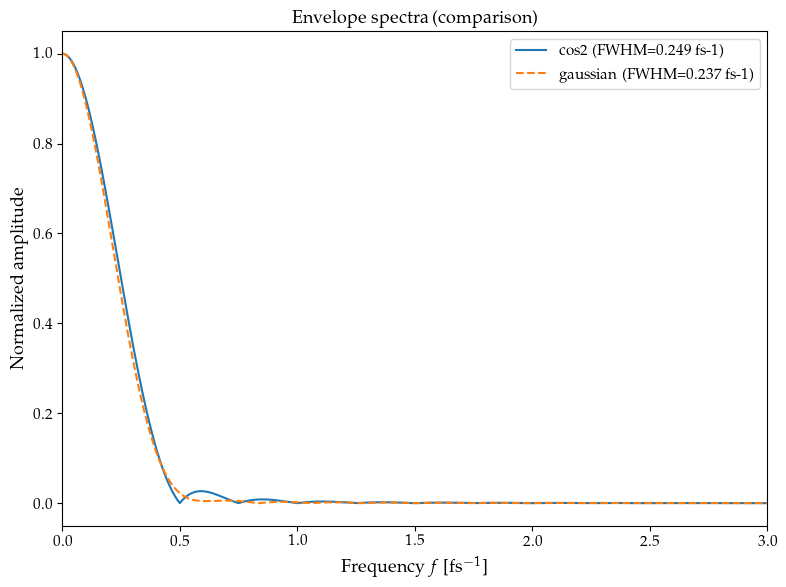

In [19]:
# =============================
# TEST 1: Independent Pulse System - Envelope Type Comparison
# =============================

print("TEST 1: NEW PULSE SYSTEM COMPARISON (cos² vs gaussian)")

# =============================
# PARAMETERS
# =============================
# (Keep short, explicit; use consistent alignment)
t_peak      = 5.0        # fs
fwhm        = 2.0        # fs (FWHM)
amplitude   = 1.0        # a.u.
carrier_cm  = 1.0        # cm^-1 (will be converted internally)
phase_val   = np.pi      # rad

# =============================
# BUILD TWO SINGLE-PULSE SEQUENCES
# =============================
seq_cos2 = LaserPulseSequence.from_general_specs(
    pulse_peak_times=t_peak,
    pulse_phases=phase_val,
    pulse_freqs=carrier_cm,
    pulse_fwhms=fwhm,
    pulse_amplitudes=amplitude,
    envelope_types="cos2",
)
seq_gauss = LaserPulseSequence.from_general_specs(
    pulse_peak_times=t_peak,
    pulse_phases=phase_val,
    pulse_freqs=carrier_cm,
    pulse_fwhms=fwhm,
    pulse_amplitudes=amplitude,
    envelope_types="gaussian",
)

print("Summary (cos2):")
seq_cos2.summary()
print("Summary (gaussian):")
seq_gauss.summary()

# =============================
# TIME GRID FOR LOCAL ANALYSIS (±1.5 * FWHM AROUND PEAK)
# =============================
local_times = np.linspace(t_peak - 1.5 * fwhm, t_peak + 1.5 * fwhm, 800)

# =============================
# PLOTTING (Envelope + RWA field) SIMPLIFIED (no helper)
# =============================
fig, axes = plt.subplots(2, 2)
plot_pulse_envelope(local_times, seq_cos2, ax=axes[0, 0], show_legend=False)
axes[0, 0].set_title("cos2 envelope")
plot_pulse_envelope(local_times, seq_gauss, ax=axes[0, 1], show_legend=False)
axes[0, 1].set_title("gaussian envelope")
plot_e_pulse(local_times, seq_cos2, ax=axes[1, 0], show_legend=False)
axes[1, 0].set_title("cos2 RWA field")
plot_e_pulse(local_times, seq_gauss, ax=axes[1, 1], show_legend=False)
axes[1, 1].set_title("gaussian RWA field")
for ax in axes.ravel():
    ax.set_xlim(local_times[0], local_times[-1])
fig.tight_layout()

# =============================
# FREQUENCY-DOMAIN COMPARISON (FFT OF ENVELOPE) SIMPLIFIED
# =============================

def spectral_envelope(times: np.ndarray, seq: LaserPulseSequence):
    """Return positive-frequency normalized magnitude + frequency axis (simple)."""
    env = pulse_envelope(times, seq)
    N   = len(times)
    dt  = times[1] - times[0]
    N_fft = 1 << (N - 1).bit_length()  # next power of two
    spec = np.fft.fft(env, n=N_fft)
    freq = np.fft.fftfreq(N_fft, dt)
    pos  = freq >= 0
    mag  = np.abs(spec[pos])
    if mag.max() > 0:
        mag /= mag.max()
    above = np.where(mag >= 0.5)[0]
    fwhm_freq = (freq[pos][above[-1]] - freq[pos][above[0]]) if len(above) > 1 else 0.0
    return freq[pos], mag, fwhm_freq

DT     = 0.05   # fs sampling
T_MAX  = 300.0  # fs
spec_t = np.arange(0.0, T_MAX, DT)

f_cos, mag_cos, f_cos_fwhm = spectral_envelope(spec_t, seq_cos2)
f_gau, mag_gau, f_gau_fwhm = spectral_envelope(spec_t, seq_gauss)

fig_spec, ax_spec = plt.subplots()
ax_spec.plot(f_cos, mag_cos, label=f"cos2 (FWHM={f_cos_fwhm:.3f} fs-1)", color=COLORS[0], linestyle=LINE_STYLES[0])
ax_spec.plot(f_gau, mag_gau, label=f"gaussian (FWHM={f_gau_fwhm:.3f} fs-1)", color=COLORS[1], linestyle=LINE_STYLES[1])
ax_spec.set_xlim(0, 3.0)
ax_spec.set_xlabel(r"Frequency $f$ [fs$^{-1}$]")
ax_spec.set_ylabel("Normalized amplitude")
ax_spec.set_title("Envelope spectra (comparison)")
ax_spec.legend()
fig_spec.tight_layout()
save_fig(fig_spec, custom_dir / "pulse_envelope_spectra_comparison")


print("\nHighlights (simplified):")
print("- Independent pulse objects")
print("- Direct envelope + spectral comparison")

## 2. Multi-Pulse Gaussian Sequence Diagnostics

In [20]:
# =============================
# TEST 2: Multi-Pulse Sequence + Comprehensive Plot
# =============================

### Time axis for evaluation
test_times = np.linspace(-2.0, 8.0, 600)

### Build sequence (3 pulses, gaussian)
complex_seq = LaserPulseSequence.from_general_specs(
    pulse_indices=[0, 1, 2],
    pulse_peak_times=[0.0, 3.0, 6.0],
    pulse_phases=[0.0, 1.57, 3.14],
    pulse_freqs=[1.0, 1.1, 0.9],
    pulse_fwhms=[1.0, 1.2, 0.8],
    pulse_amplitudes=[1.0, 1.5, 0.8],
    envelope_types="gaussian",
)

print("TEST 2: Complex gaussian sequence (3 pulses)")
complex_seq.summary()

### All-in-one diagnostic plot
fig_all = plot_all_pulse_components(test_times, complex_seq)
print("✓ Generated combined diagnostic plot (envelope, RWA, full field) with configured styles")

TEST 2: Complex gaussian sequence (3 pulses)
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   0.00 fs | E₀ = 1.000e+00 | FWHM =  1.0 fs | ω =     0.00 rad/fs | ϕ =  0.000 rad | type = gaussian
Pulse  1: t =   3.00 fs | E₀ = 1.500e+00 | FWHM =  1.2 fs | ω =     0.00 rad/fs | ϕ =  1.570 rad | type = gaussian
Pulse  2: t =   6.00 fs | E₀ = 8.000e-01 | FWHM =  0.8 fs | ω =     0.00 rad/fs | ϕ =  3.140 rad | type = gaussian
✓ Generated combined diagnostic plot (envelope, RWA, full field) with configured styles


<Figure size 800x600 with 0 Axes>

## 3. Overlap / Active Region Analysis

In [21]:
# =============================
# TEST 3: Overlap Analysis (Active Regions + Total Amplitude)
# =============================

overlap_times = np.linspace(-2.0, 10.0, 400)

overlap_seq = LaserPulseSequence.from_general_specs(
    pulse_indices=[0, 1, 0, 2],
    pulse_peak_times=[1.0, 3.0, 5.0, 7.0],
    pulse_phases=[0.0, 1.57, 3.14, 0.5],
    pulse_freqs=[1.0, 1.2, 1.0, 0.8],
    pulse_fwhms=[0.8, 1.2, 0.8, 1.5],
    pulse_amplitudes=[1.0, 1.5, 1.0, 2.0],
    envelope_types="cos2",
)

print("TEST 3: Overlap sequence summary")
overlap_seq.summary()

# Vectorized quantities
env_vals     = pulse_envelope(overlap_times, overlap_seq)
E_complex    = E_pulse(overlap_times, overlap_seq)
E0_values    = np.array([overlap_seq.get_total_amplitude_at_time(t) for t in overlap_times])
num_active   = np.array([overlap_seq.get_field_info_at_time(t)["num_active_pulses"] for t in overlap_times])
active_mask  = identify_non_zero_pulse_regions(overlap_times, overlap_seq)

fig, axs = plt.subplots(3, 1, sharex=True)

# (1) Total amplitude trace
color_amp = COLORS[0]
axs[0].plot(overlap_times, E0_values, color=color_amp, linestyle=LINE_STYLES[0], label=r"$E_0(t)$ total amplitude")
for i, p in enumerate(overlap_seq.pulses):
    axs[0].axvline(p.pulse_peak_time, color=f"C{(i+1)%10}", linestyle=LINE_STYLES[i], alpha=0.55,
                   label=fr"Pulse {i} peak" if i < 5 else None)
axs[0].set_ylabel(r"$E_0$ [a.u.]")
axs[0].set_title("Total electric field amplitude vs time")
axs[0].legend(loc="upper left", ncol=2, )

# (2) Active pulse count
axs[1].step(overlap_times, num_active, where="mid", color=COLORS[1], label="\# active pulses")
axs[1].set_ylabel("Active count")
axs[1].set_title("Pulse overlap (count of simultaneously active pulses)")
axs[1].legend()

# (3) Envelope + shaded active regions
axs[2].plot(overlap_times, env_vals, color=color_amp, label="Envelope sum")
axs[2].fill_between(overlap_times, env_vals, where=active_mask, color=COLORS[2], alpha=0.18, label="Active regions")
axs[2].set_xlabel(r"Time $t$ [fs]")
axs[2].set_ylabel("Envelope")
axs[2].set_title("Combined envelope with active support")
axs[2].legend()

fig.tight_layout()
save_fig(fig, custom_dir / "pulse_overlap_analysis")
print("✓ Overlap + active-region analysis complete (styled)")

TEST 3: Overlap sequence summary
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   1.00 fs | E₀ = 1.000e+00 | FWHM =  0.8 fs | ω =     0.00 rad/fs | ϕ =  0.000 rad | type = cos2   
Pulse  1: t =   3.00 fs | E₀ = 1.500e+00 | FWHM =  1.2 fs | ω =     0.00 rad/fs | ϕ =  1.570 rad | type = cos2   
Pulse  0: t =   5.00 fs | E₀ = 1.000e+00 | FWHM =  0.8 fs | ω =     0.00 rad/fs | ϕ =  3.140 rad | type = cos2   
Pulse  2: t =   7.00 fs | E₀ = 2.000e+00 | FWHM =  1.5 fs | ω =     0.00 rad/fs | ϕ =  0.500 rad | type = cos2   


RuntimeError: latex was not able to process the following string:
b'\\\\\\\\\\\\# active pulses'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp8dgx4n4i 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
 (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/tools\bm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: There's no line here to end.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily \\\#
                     active pulses}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\71\69\tmp8dgx4n4i\71
69adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.log.




Error in callback <function _draw_all_if_interactive at 0x00000225CB17A5C0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'\\\\\\\\\\\\# active pulses'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpiujnz4fj 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
 (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/tools\bm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: There's no line here to end.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily \\\#
                     active pulses}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\71\69\tmpiujnz4fj\71
69adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.log.




RuntimeError: latex was not able to process the following string:
b'\\\\\\\\\\\\# active pulses'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmproubpykg 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
 (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/tools\bm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 7169adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: There's no line here to end.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\rmfamily \\\#
                     active pulses}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\71\69\tmproubpykg\71
69adca96c3fdf2402fb79acd4f8e159e2ffa82f99775e6e6cfc5be4d283c0d.log.




<Figure size 800x600 with 3 Axes>

## 4. Advanced Plotting Demonstrations

In [11]:
# =============================
# TEST 4: Advanced Plotting Demonstrations
# =============================

adv_times = np.linspace(-3.0, 10.0, 700)
adv_seq = LaserPulseSequence.from_general_specs(
    pulse_peak_times=[0.0, 4.0, 8.0],
    pulse_phases=[0.0, 2.0, 4.0],
    pulse_freqs=[0.8, 1.0, 1.2],
    pulse_fwhms=[1.5, 1.0, 1.2],
    pulse_amplitudes=[2.0, 1.0, 1.8],
    envelope_types="cos2",
)

print("TEST 4: Advanced plotting sequence summary")
adv_seq.summary()

print("Generating: envelope, RWA field, full field, combined components (styled)...")
fig_env, _  = plot_pulse_envelope(adv_times, adv_seq)
fig_rwa, _  = plot_e_pulse(adv_times, adv_seq)
fig_full, _ = plot_epsilon_pulse(adv_times, adv_seq)
fig_all     = plot_all_pulse_components(adv_times, adv_seq)
print("✓ Advanced plotting produced 4 figures with configured styles")

TEST 4: Advanced plotting sequence summary
LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   0.00 fs | E₀ = 2.000e+00 | FWHM =  1.5 fs | ω =     0.00 rad/fs | ϕ =  0.000 rad | type = cos2   
Pulse  1: t =   4.00 fs | E₀ = 1.000e+00 | FWHM =  1.0 fs | ω =     0.00 rad/fs | ϕ =  2.000 rad | type = cos2   
Pulse  2: t =   8.00 fs | E₀ = 1.800e+00 | FWHM =  1.2 fs | ω =     0.00 rad/fs | ϕ =  4.000 rad | type = cos2   
Generating: envelope, RWA field, full field, combined components (styled)...
✓ Advanced plotting produced 4 figures with configured styles


<Figure size 800x600 with 0 Axes>

In [12]:
# =============================
# TEST 5: QuTiP Solver Options Sanity Check
# =============================
from qutip import *  # (keep for interactive notebook convenience)

final_solver_options = {
    "store_states": True,
    "store_final_state": False,
    "progress_bar": "",   # suppress
    "rtol": 1e-4,
}


def run_simple_mesolve(duration: float = 10.0, n_steps: int = 2000):
    """Run a minimal TLS evolution to validate solver options.

    Parameters
    ----------
    duration : float
        Total simulation time (fs)
    n_steps : int
        Number of points in tlist (dense enough for test)
    """
    ### System (two-level system example)
    H      = sigmax()        # simple Hamiltonian
    psi0   = ket2dm(basis(2, 0))
    tlist  = np.linspace(0.0, duration, n_steps)

    ### Observables
    e_ops  = [sigmax(), sigmay(), sigmaz()]

    ### Merge user options into qutip.Options
    opt = Options(
        store_states=final_solver_options["store_states"],
        store_final_state=final_solver_options["store_final_state"],
        rtol=final_solver_options["rtol"],
        progress_bar=final_solver_options["progress_bar"],
    )

    res = mesolve(H, psi0, tlist, [], e_ops, options=opt)
    return res

solver_result = run_simple_mesolve()
print("TEST 5: mesolve complete -> captured", len(solver_result.states), "states")

TEST 5: mesolve complete -> captured 2000 states


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


## 5. Solver Options (QuTiP)

In [13]:
# =============================
# TEST 6: Polarization Calculation (Requires AtomicSystem)
# =============================
from qspectro2d.spectroscopy import complex_polarization
from qspectro2d.core.atomic_system.system_class import AtomicSystem

atom_sys = AtomicSystem()  # default single atom
Dip = atom_sys.dipole_op
pol = complex_polarization(Dip, solver_result.states)
print(f"TEST 6: polarization array shape = {pol.shape}, first value = {pol[0]:.3e}")

TEST 6: polarization array shape = (2000,), first value = 0.000e+00+0.000e+00j


## 6. Polarization Calculation

In [14]:
# =============================
# TEST 7: Inhomogeneity Sampling
# =============================
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian

n_freqs = 10
D       = 2
x0      = 60
samples_x = sample_from_gaussian(n_freqs, D, x0)
samples_y = sample_from_gaussian(n_freqs, D, x0)
print("TEST 7: Gaussian samples (paired):")
for i, (sx, sy) in enumerate(zip(samples_x, samples_y)):
    print(f"  {i:02d}: {sx:6.2f}, {sy:6.2f}")
print("✓ Inhomogeneity sampling ok")

TEST 7: Gaussian samples (paired):
  00:  59.16,  60.43
  01:  61.01,  60.79
  02:  58.33,  60.34
  03:  59.88,  60.65
  04:  60.05,  61.73
  05:  59.56,  61.41
  06:  60.37,  61.13
  07:  60.37,  60.02
  08:  58.86,  59.89
  09:  59.05,  59.75
✓ Inhomogeneity sampling ok


## 7. Inhomogeneity Sampling

✓ spectral_envelope basic test passed (FWHM ~ 0.0977)
n= 1 pulses ->    0.28 ms
n= 2 pulses ->    0.21 ms
n= 4 pulses ->    0.37 ms
n= 8 pulses ->    0.95 ms
n=16 pulses ->    0.77 ms
✓ Performance profiling complete (styled)


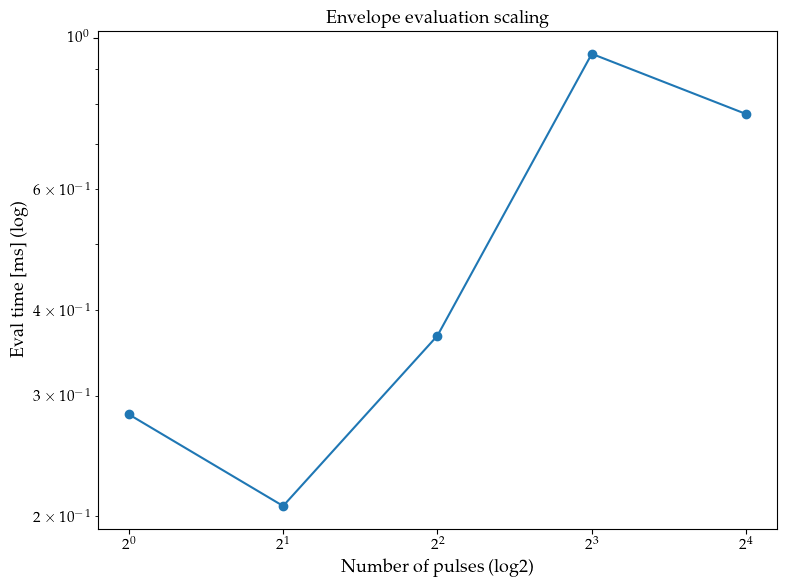

In [ ]:
# =============================
# TEST 8A: Unit tests for spectral_envelope helper (lightweight)
# =============================
import time

def _test_spectral_envelope_basic():
    t = np.linspace(0, 50, 1001)
    seq = LaserPulseSequence.from_general_specs(
        pulse_peak_times=25.0,
        pulse_phases=0.0,
        pulse_freqs=1.0,
        pulse_fwhms=5.0,
        pulse_amplitudes=1.0,
        envelope_types='cos2',
    )
    f, mag, fwhm_val = spectral_envelope(t, seq)
    assert mag.max() <= 1.00001 and mag.min() >= 0.0, 'Magnitude normalization failed'
    assert f[0] >= 0.0, 'Frequency axis not restricted to positive domain'
    assert fwhm_val >= 0.0, 'FWHM must be non-negative'
    return fwhm_val

fwhm_test = _test_spectral_envelope_basic()
print(f"✓ spectral_envelope basic test passed (FWHM ~ {fwhm_test:.4f})")

# =============================
# TEST 8B: Performance profiling (envelope evaluation scaling)
# =============================
PULSE_COUNTS = [1, 2, 4, 8, 16]
TIMES = np.linspace(-10, 60, 4000)
results_perf = []
for n in PULSE_COUNTS:
    seq = LaserPulseSequence.from_general_specs(
        pulse_peak_times=np.linspace(0, 50, n),
        pulse_phases=[0.0]*n,
        pulse_freqs=[1.0]*n,
        pulse_fwhms=[5.0]*n,
        pulse_amplitudes=[1.0]*n,
        envelope_types=['gaussian']*n,
    )
    t0 = time.perf_counter()
    _ = pulse_envelope(TIMES, seq)
    dt = time.perf_counter() - t0
    results_perf.append(dt)
    print(f"n={n:2d} pulses -> {dt*1e3:7.2f} ms")

fig_perf, ax_perf = plt.subplots()
ax_perf.plot(PULSE_COUNTS, np.array(results_perf)*1e3, marker=MARKERS[0], color=COLORS[0], linestyle=LINE_STYLES[0])
ax_perf.set_xscale('log', base=2)
ax_perf.set_yscale('log')
ax_perf.set_xlabel('Number of pulses (log2)')
ax_perf.set_ylabel('Eval time [ms] (log)')
ax_perf.set_title('Envelope evaluation scaling')
fig_perf.tight_layout()
print('✓ Performance profiling complete (styled)')

## 8. Spectral Envelope Unit Test & Performance Profiling